In [67]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cmcrameri import cm
import numpy as np

In [68]:
## Import full enrichment results
data_dir = r"C:\Users\neil_\DellXPS_June2024\OneDrive\Desktop\New UHN\Precision Medicine\carotid_plaque\workflow\pathway_enrichment\\"
kegg_mirna = pd.read_csv(data_dir+"dem_pathways_kegg.csv")
go_mirna = pd.read_csv(data_dir+"dem_pathways_go.csv")
go_mirna.drop(columns=["pthwy_id"],inplace=True)

In [69]:
## Import filtered lists (filtered by SR)
data_dir = r"C:\Users\neil_\DellXPS_June2024\OneDrive\Desktop\New UHN\Precision Medicine\carotid_plaque\data\filtered_lists\\"
kegg_top = pd.read_csv(data_dir+"dem_kegg_top.txt", sep="\t", header=None) # NP removed redundant pathways "Longevity regulating pathway - multiple species", "Apoptosis - multiple species"
kegg_ec =  pd.read_csv(data_dir+"dem_kegg_ec.txt", sep="\t", header=None)

go_top = pd.read_csv(data_dir+"dem_go_top.txt", sep="\t", header=None)
go_ec =  pd.read_csv(data_dir+"dem_go_ec.txt", sep="\t", header=None)

In [70]:
class Enrichment:
    def __init__(self, db, all_df, top_df, ec_df):
        self.database = db
        self.enrichment_df = all_df
        self.top_pathways = list(set(top_df[0]))
        self.endo_pathways = list(set(ec_df[0]))

In [71]:
GO_miRNA = Enrichment("GO BP", go_mirna, go_top, go_ec)
KEGG_miRNA = Enrichment("KEGG", kegg_mirna, kegg_top, kegg_ec)

In [72]:
def get_ec_df(full_df, ec_pthwys):
    filtered_df = full_df[full_df["pathway"].isin(ec_pthwys)]
    return filtered_df


In [73]:
def get_pivot_df(filtered_df):
    pivot_df = filtered_df.pivot_table(index='pathway', columns='cohort', values='fold_enrichment')
    # Ensure 'symptomatic' and 'asymptomatic' columns exist with default values set to 1.0 if they don't
    if 'symptomatic' not in pivot_df.columns:
        pivot_df['symptomatic'] = np.nan
    if 'asymptomatic' not in pivot_df.columns:
        pivot_df['asymptomatic'] = np.nan
    
    # Reorder columns to ensure 'symptomatic' and 'asymptomatic' are in the right place if needed
    pivot_df = pivot_df[['asymptomatic', 'symptomatic']]

    pivot_df.fillna(1.0, inplace=True)
    return pivot_df

In [74]:
def filter_pivot_by_variation(pivot_df, n=30):
    variation = pivot_df.std(axis=1)
    top_n_labels = variation.nlargest(n).index
    filtered_pivot = pivot_df.loc[top_n_labels]
    return filtered_pivot

In [75]:
for Enr in [GO_miRNA, KEGG_miRNA]:
    full_df = Enr.enrichment_df
    ec_pthwys = Enr.endo_pathways
    # Only include pathways specified by SR
    Enr.filtered_df = get_ec_df(full_df, ec_pthwys)
    pivot_df = get_pivot_df(Enr.filtered_df)
    Enr.pivot_df = filter_pivot_by_variation(pivot_df)

## GO

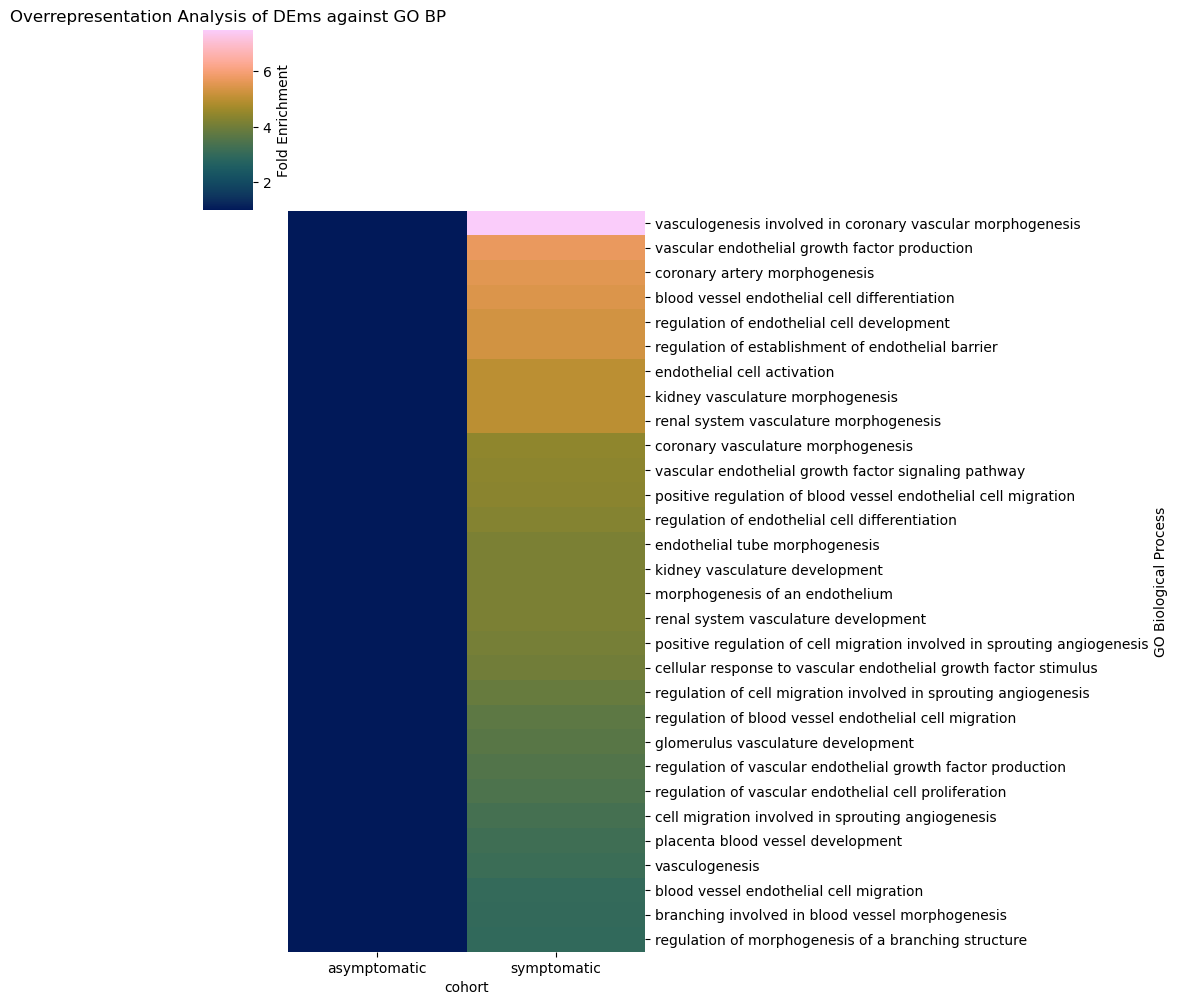

In [76]:
Enr = GO_miRNA
db = Enr.database
pivot_df = Enr.pivot_df.rename_axis("GO Biological Process")

# Plot 30 pathways heatmap
f = sns.clustermap(pivot_df,cmap=cm.batlow, figsize=(10, 10), annot=False, row_cluster=False, col_cluster=False)
#f = sns.clustermap(pivot_df, cmap=cm.batlow, figsize=(12, 12), annot=False)

plt.title(f'Overrepresentation Analysis of DEms against {db}')
plt.ylabel('Fold Enrichment')

f.savefig(f"dem_go_heatmap_ec.pdf")
plt.show()

ANOVA test results: F-value = 319.1214464285833, p-value = 2.983780273513647e-25
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1       group2   meandiff p-adj lower  upper  reject
------------------------------------------------------------
asymptomatic symptomatic   3.2962   0.0 2.9269 3.6656   True
------------------------------------------------------------


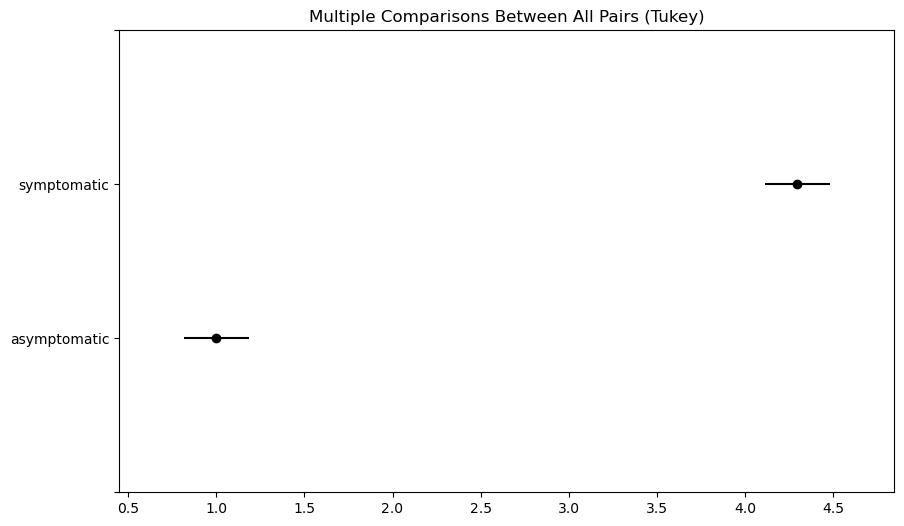

In [77]:
### Bar plots
# Perform ANOVA between cohorts for endo pathway overrep

from scipy import stats

fvalue, pvalue = stats.f_oneway(pivot_df['symptomatic'],
                                pivot_df['asymptomatic'])
print(f"ANOVA test results: F-value = {fvalue}, p-value = {pvalue}")

# Post-hoc Analysis (Tukey's HSD)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt



# Reshape the DataFrame for Tukey's HSD
melted_df = pivot_df.melt(var_name='cohort', value_name='value', ignore_index=False).reset_index()

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=melted_df['value'], groups=melted_df['cohort'], alpha=0.05)
tukey.plot_simultaneous()
print(tukey)

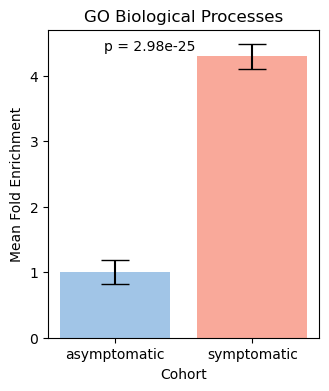

In [78]:
means = tukey._multicomp.groupstats.groupmean
error_bar_length = tukey.halfwidths[0]


# Plotting the bar graph
fig, ax = plt.subplots(figsize=(3.5,4))
cohorts = ['asymptomatic', 'symptomatic']
x_pos = range(len(cohorts))

# Create bars with error bars
bars = ax.bar(x_pos, means, yerr=error_bar_length, align='center', alpha=0.7, color=[colors[cohort] for cohort in cohorts], capsize=10)

# Adding labels
ax.set_xlabel('Cohort')
ax.set_ylabel('Mean Fold Enrichment')
ax.set_xticks(x_pos)
ax.set_xticklabels(cohorts)
ax.set_ylim(bottom=0)
ax.set_title('GO Biological Processes')

ax.text(0.25, 4.35, f'p = {pvalue:.2e}', ha='center', va='bottom')
# Show plot
plt.show()

fig.savefig(f"dem_go_tukey_ec.pdf")

## KEGG

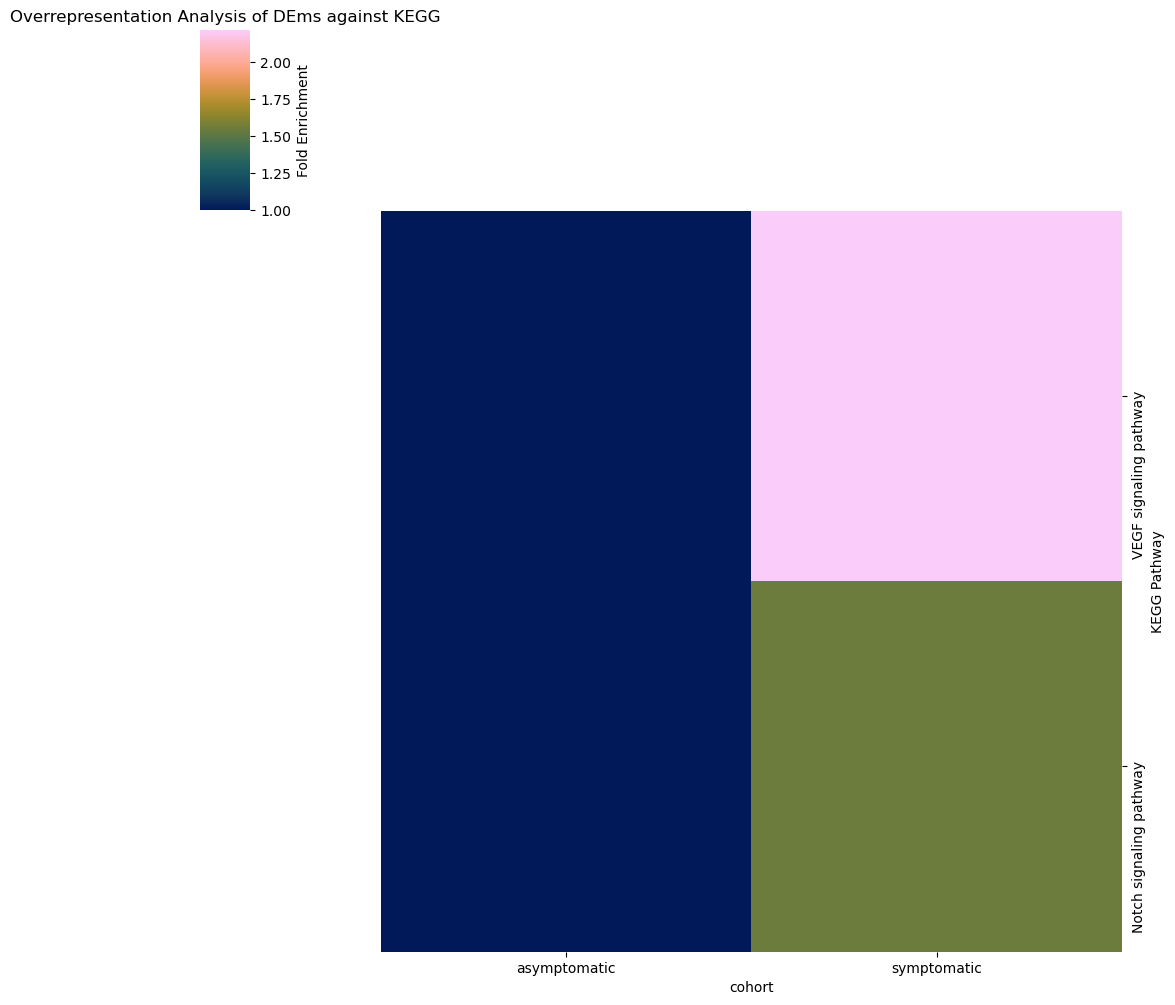

In [79]:
Enr = KEGG_miRNA
db = Enr.database
pivot_df = Enr.pivot_df.rename_axis("KEGG Pathway")

# Plot 30 pathways heatmap
f = sns.clustermap(pivot_df,cmap=cm.batlow, figsize=(10, 10), annot=False, row_cluster=False, col_cluster=False)
#f = sns.clustermap(pivot_df, cmap=cm.batlow, figsize=(12, 12), annot=False)

plt.title(f'Overrepresentation Analysis of DEms against {db}')
plt.ylabel('Fold Enrichment')

f.savefig(f"dem_kegg_heatmap_ec.pdf")
plt.show()

ANOVA test results: F-value = 7.0507629588310925, p-value = 0.11737655016654289
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1       group2   meandiff p-adj  lower  upper  reject
-------------------------------------------------------------
asymptomatic symptomatic   0.8818 0.1174 -0.547 2.3106  False
-------------------------------------------------------------


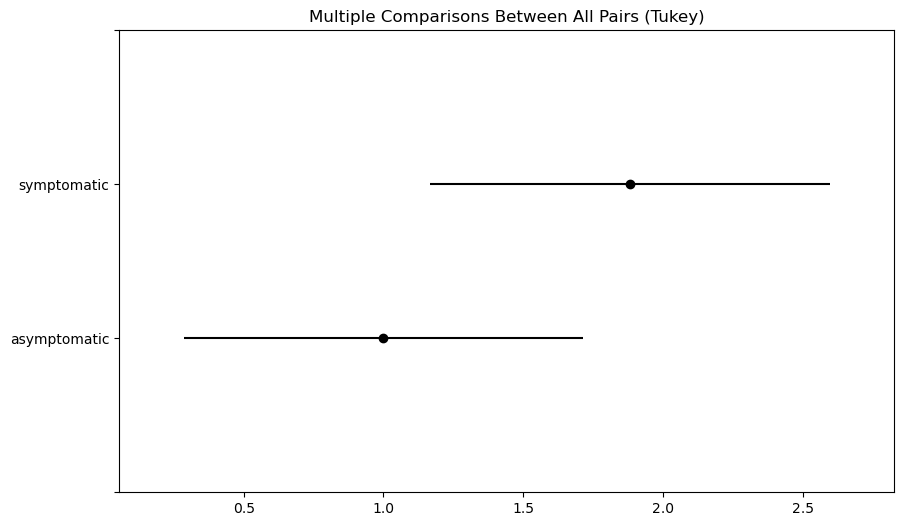

In [80]:
fvalue, pvalue = stats.f_oneway(pivot_df['symptomatic'],
                                pivot_df['asymptomatic'])
print(f"ANOVA test results: F-value = {fvalue}, p-value = {pvalue}")



# Reshape the DataFrame for Tukey's HSD
melted_df = pivot_df.melt(var_name='cohort', value_name='value', ignore_index=False).reset_index()

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=melted_df['value'], groups=melted_df['cohort'], alpha=0.05)
tukey.plot_simultaneous()
print(tukey)

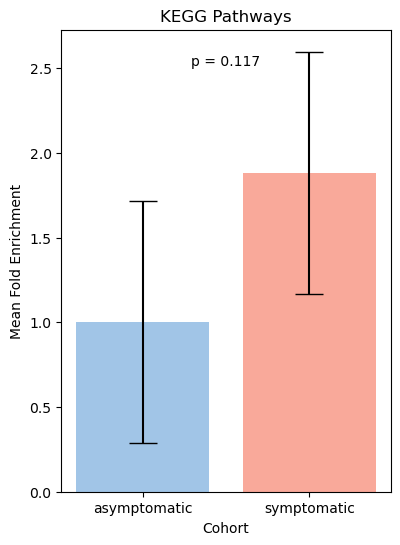

In [84]:
means = tukey._multicomp.groupstats.groupmean
error_bar_length = tukey.halfwidths[0]

# Lower ends of error bars
lowers = means - error_bar_length

# Upper ends of error bars
uppers = means + error_bar_length

# Define colors for each cohort
colors = {'asymptomatic': '#7AADDD', 'symptomatic': '#F78570'}

# Plotting the bar graph
fig, ax = plt.subplots(figsize=(4.25,6))
cohorts = ['asymptomatic', 'symptomatic']
x_pos = range(len(cohorts))

# Create bars with error bars
bars = ax.bar(x_pos, means, yerr=error_bar_length, align='center', alpha=0.7, color=[colors[cohort] for cohort in cohorts], capsize=10)

# Adding labels
ax.set_xlabel('Cohort')
ax.set_ylabel('Mean Fold Enrichment')
ax.set_xticks(x_pos)
ax.set_xticklabels(cohorts)
ax.set_ylim(bottom=0)
ax.set_title('KEGG Pathways')

ax.text(0.5, 2.5, f'p = {pvalue:.3f}', ha='center', va='bottom')
# Show plot
plt.show()

fig.savefig(f"dem_kegg_tukey_ec.pdf")